In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from transformers import AutoModel, AutoTokenizer

from group_sae.utils import palette

Triton not installed, using eager implementation of SAE decoder.


## FLOPs

In [30]:
from torch.utils.flop_counter import FlopCounterMode

device = "cuda"

# Load GPT-2 model and tokenizer
model_name = "EleutherAI/pythia-1b-deduped"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.to(device)
model.eval()
print("Model running on", device)

Model running on cuda


In [31]:
N_TOKENS = 1e9
ctx_len = 1024
d_model = 2048
n_layers = 16
n_batches = N_TOKENS // ctx_len

In [ ]:
# Prepare a sample input with 1024 tokens
input_text = "Sample input."
input_text += " null" * (ctx_len - len(tokenizer(input_text)["input_ids"]))
inputs = tokenizer(input_text, return_tensors="pt")["input_ids"]
print(f"Input shape: {inputs.shape}")

cache = {}


def forward_hook(module, input, output):
    cache["output"] = output[0].flatten(0, 1)


model.layers[0].register_forward_hook(forward_hook)

# Enable flop counting
with FlopCounterMode(model) as flop_counter:
    with torch.no_grad():
        outputs = model(inputs.to(device))

# Retrieve FLOPs count
flops = flop_counter.get_total_flops() * n_batches
print(f"PFLOPs required for caching 1B tokens: {flops / 1e15:.2f} PFLOPs")

Input shape: torch.Size([1, 1024])
Module                                                FLOP    % Total
-----------------------------------------------  ---------  ---------
GPTNeoXModel                                     1786.706B    100.00%
 - aten.bmm                                         0.000B      0.00%
 - aten.addmm                                    1649.267B     92.31%
 - aten._scaled_dot_product_efficient_attention   137.439B      7.69%
 GPTNeoXModel.rotary_emb                            0.000B      0.00%
  - aten.bmm                                        0.000B      0.00%
PFLOPs required for caching 1B tokens: 1744.83 PFLOPs


/tmp/ipykernel_4316/3655135618.py:14: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model) as flop_counter:


In [33]:
import torch.nn as nn


# We use a standard SAE as FLOP count doesn't change between architectures.
class SAE(nn.Module):
    def __init__(self, c, sparsity=1):
        super(SAE, self).__init__()
        self.sparsity = sparsity
        self.encoder = nn.Linear(d_model, d_model * c)
        self.decoder = nn.Linear(d_model * c, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.encoder(x)
        h = self.relu(h)
        return self.decoder(h), h

    def get_loss(self, x, y):
        x_hat, h = self(x)
        l2_loss = (x_hat - y).pow(2).sum()
        fvu = l2_loss / x.pow(2).sum()
        l1_loss = h.abs().sum(-1).mean()
        print(f"l2_loss: {l2_loss.item()}, l1_loss: {l1_loss.item()}")
        return fvu + l1_loss * self.sparsity

In [34]:
def training_step(sae, inputs, optimizer):
    optimizer.zero_grad()
    loss = sae.get_loss(inputs, inputs)
    loss.backward()
    optimizer.step()


c = 16

sae = SAE(c=c, sparsity=1)
sae.to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)

In [35]:
# Enable flop counting
with FlopCounterMode(sae) as flop_counter:
    training_step(sae, cache["output"], optimizer)

# Retrieve FLOPs count
flops = flop_counter.get_total_flops() * n_batches  # * n_layers
print(f"PFLOPs for the forward pass: {flops / 1e15:.2f} PFLOPs")

l2_loss: 909004.0, l1_loss: 4792.55224609375
Module               FLOP    % Total
---------------  --------  ---------
Global           687.195B    100.00%
 - aten.addmm    274.878B     40.00%
 - aten.mm       412.317B     60.00%
 SAE             412.317B     60.00%
  - aten.addmm   274.878B     40.00%
  - aten.mm      137.439B     20.00%
  SAE.decoder    412.317B     60.00%
   - aten.addmm  137.439B     20.00%
   - aten.mm     274.878B     40.00%
  SAE.encoder    274.878B     40.00%
   - aten.addmm  137.439B     20.00%
   - aten.mm     137.439B     20.00%
PFLOPs for the forward pass: 671.09 PFLOPs


/tmp/ipykernel_4316/4198970078.py:2: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(sae) as flop_counter:


| Model       |  L |    D |       A |      T |
|-------------|----|------|---------|--------|
| Pythia-160m | 12 |  768 |  207.62 |  94.37 |
| Pythia-410m | 24 | 1024 |  704.64 | 167.77 |
| Pythia-1b   | 16 | 2048 | 1744.83 | 671.09 |

All results are in PFLOPs (1e15)

## AMD

In [121]:
import numpy as np

from group_sae import MODEL_MAP
from group_sae.utils import load_amds, load_cluster_map

columns = ["ce_loss_score", "delta_ce", "explained_variance", "mse", "l2_ratio", "layer", "G"]

def delta_ce(df):
    return (df["ce_loss_with_sae"] - df["ce_loss_without_sae"]) / df["ce_loss_without_sae"] * 100

def load_cluster_eval(size, include_baseline=False):

    nl = MODEL_MAP[f"pythia-{size}"]["n_layers"]

    labels = []
    clusters = []
    for c in load_cluster_map(size).values():
        lab_ = list(dict.fromkeys(c))
        label_map = {v: i for i, v in enumerate(lab_)}
        clusters += [label_map[i] for i in c]
        labels += c
    labels += [f"layers.{i}" for i in range(nl-1)]
    clusters += list(range(nl-1))

    cluster_eval = pd.read_csv(f"../eval/pythia-{size}_cluster.csv", index_col=0)
    cluster_eval["delta_ce"] = delta_ce(cluster_eval)
    cluster_eval = cluster_eval[columns]
    cluster_eval["label"] = labels[: len(cluster_eval)]
    cluster_eval.drop(columns="G", inplace=True)

    base_eval = pd.read_csv(f"../eval/pythia-{size}_baseline.csv", index_col=0)
    base_eval["delta_ce"] = delta_ce(base_eval)
    base_eval = base_eval[columns]
    base_eval["label"] = base_eval["layer"].apply(lambda x: f"layers.{x}")
    base_eval.drop(columns="G", inplace=True)

    unique_eval = pd.concat([base_eval, cluster_eval]).drop_duplicates()

    empty_evals = pd.DataFrame(
        {"layer": list(range(nl-1)) * (nl-1), "cluster": clusters, "label": labels, "G": np.arange(1, nl).repeat(nl - 1)}
    )
    eval = pd.merge(empty_evals, unique_eval, how="left").drop(columns="label")
    eval = eval.groupby(["G", "cluster", "layer"]).mean().reset_index()

    # Fill AMDs
    amd = load_amds(size, include_baseline)

    return pd.merge(eval, amd, on="G")

In [122]:
p160 = load_cluster_eval("160m", include_baseline=True)
p410 = load_cluster_eval("410m", include_baseline=True)
p1 = load_cluster_eval("1b", include_baseline=True)

In [123]:
p160_plot = p160.groupby("G").mean()
p410_plot = p410.groupby("G").mean()
p1_plot = p1.groupby("G").mean()

In [124]:
base_160m = pd.read_csv("../eval/pythia-160m_baseline.csv", index_col=0)
base_160m["delta_ce"] = delta_ce(base_160m)
base_160m = base_160m[columns]

base_410m = pd.read_csv("../eval/pythia-410m_baseline.csv", index_col=0)
base_410m["delta_ce"] = delta_ce(base_410m)
base_410m = base_410m[columns]

base_1b = pd.read_csv("../eval/pythia-1b_baseline.csv", index_col=0)
base_1b["delta_ce"] = delta_ce(base_1b)
base_1b = base_1b[columns]

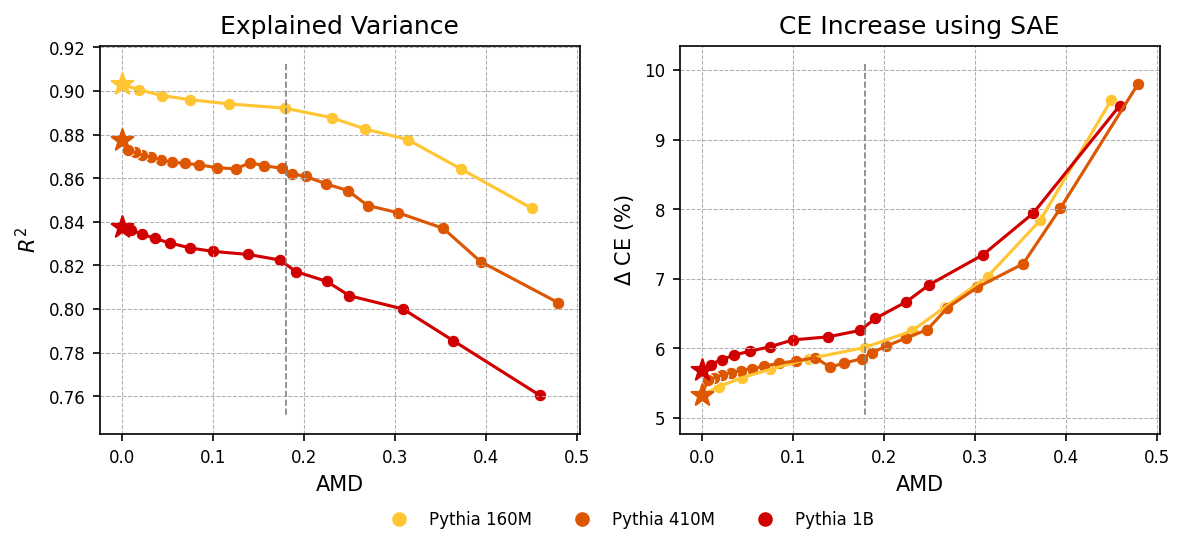

In [125]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), dpi=150, layout="tight")

def plot_vs_amd(metric, ax):
    sns.lineplot(p160_plot, x="AMD", y=metric, color=palette[0], ax=ax)
    sns.scatterplot(p160_plot, x="AMD", y=metric, color=palette[0], ax=ax, legend=False)
    last_row = p160_plot.iloc[-1]
    ax.scatter(last_row["AMD"], last_row[metric], marker="*", s=120,
               color=palette[0], edgecolor=None, zorder=10)

    sns.lineplot(p410_plot, x="AMD", y=metric, color=palette[2], ax=ax)
    sns.scatterplot(p410_plot, x="AMD", y=metric, color=palette[2], ax=ax, legend=False)
    last_row = p410_plot.iloc[-1]
    ax.scatter(last_row["AMD"], last_row[metric], marker="*", s=120,
               color=palette[2], edgecolor=None, zorder=10)

    sns.lineplot(p1_plot, x="AMD", y=metric, color=palette[3], ax=ax)
    sns.scatterplot(p1_plot, x="AMD", y=metric, color=palette[3], ax=ax, legend=False)
    last_row = p1_plot.iloc[-1]
    ax.scatter(last_row["AMD"], last_row[metric], marker="*", s=120,
               color=palette[3], edgecolor=None, zorder=10)

    all_ = pd.concat([p160_plot, p410_plot, p1_plot])
    max_ = all_[metric].max()
    min_ = all_[metric].min()
    delta = (max_ - min_) / 15
    ax.vlines(0.18, max_+delta, min_-delta, colors="grey", linestyles="--", linewidth=0.8)

    ax.set_xlabel("AMD")
    ax.tick_params(labelsize=8)  # Reduce tick size

plot_vs_amd("explained_variance", ax[0])
ax[0].set_ylabel(r"$R^2$")
ax[0].set_title("Explained Variance")
ax[0].grid(linestyle="--", linewidth=0.5)

plot_vs_amd("delta_ce", ax[1])
ax[1].set_ylabel(r"$\Delta$ CE (%)")
ax[1].set_title("CE Increase using SAE")
ax[1].grid(linestyle="--", linewidth=0.5)

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker='o', color=palette[0], linestyle='', label="Pythia 160M"),
    plt.Line2D([0], [0], marker='o', color=palette[2], linestyle='', label="Pythia 410M"),
    plt.Line2D([0], [0], marker='o', color=palette[3], linestyle='', label="Pythia 1B")
]
# bbox
fig.legend(handles=handles, loc="lower center", ncol=3, fontsize=8, frameon=False, bbox_to_anchor=(0.53, -0.05))
#fig.suptitle("AMD vs. Reconstruction metrics", fontsize=14)

plt.savefig("imgs/amd_vs_metrics.svg", bbox_inches="tight", dpi=300)
plt.show()

In [126]:
p160 = load_cluster_eval("160m", include_baseline=True)
p410 = load_cluster_eval("410m", include_baseline=True)
p1 = load_cluster_eval("1b", include_baseline=True)

In [127]:
p160_plot = p160.groupby("G").mean()
p410_plot = p410.groupby("G").mean()
p1_plot = p1.groupby("G").mean()

In [128]:
p160_plot

,cluster,layer,ce_loss_score,delta_ce,explained_variance,mse,l2_ratio,AMD,C
G,,,,,,,,,
1,0.000000,5.0,0.970780,9.572593,0.846255,0.002580,0.939488,0.450,301.99
2,0.363636,5.0,0.976052,7.842404,0.864362,0.002173,0.947111,0.372,396.36
3,1.090909,5.0,0.978472,7.030484,0.877696,0.002043,0.951346,0.314,490.73
4,1.272727,5.0,0.979834,6.591543,0.882625,0.001906,0.953196,0.267,585.10
5,1.818182,5.0,0.980873,6.251327,0.887733,0.001844,0.954871,0.231,679.47
6,2.636364,5.0,0.981589,6.012270,0.892167,0.001810,0.956299,0.179,773.84
7,2.909091,5.0,0.982074,5.852547,0.894096,0.001767,0.957037,0.118,868.21
8,3.000000,5.0,0.982545,5.697197,0.896020,0.001703,0.957965,0.075,962.58
9,3.454545,5.0,0.982896,5.578488,0.897933,0.001678,0.958906,0.044,1056.95


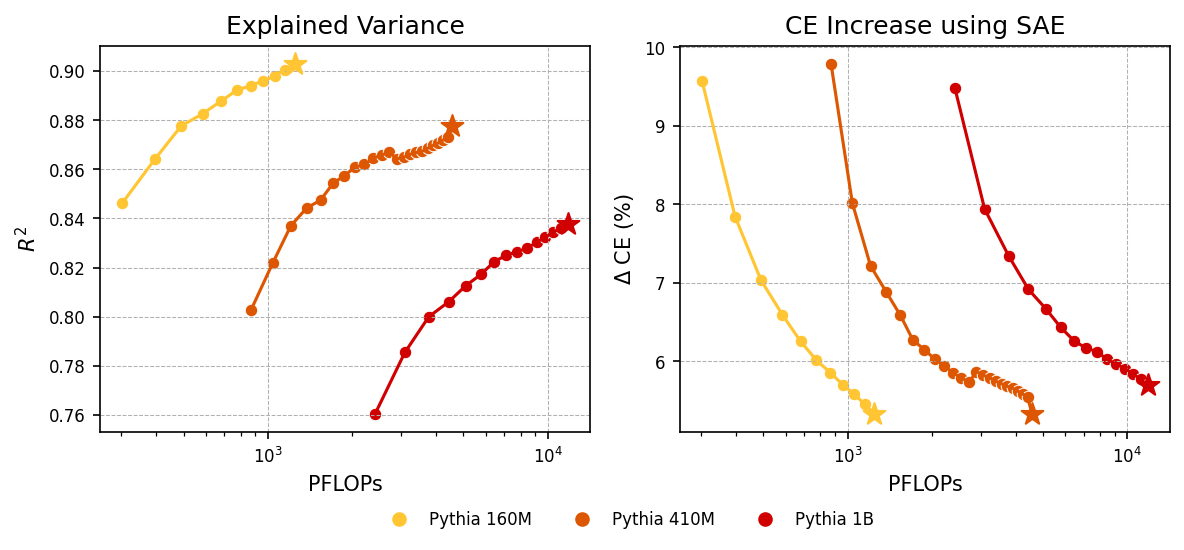

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), dpi=150, layout="tight")
ax[0].grid(linestyle="--", linewidth=0.5)
ax[1].grid(linestyle="--", linewidth=0.5)

def plot_vs_flops(metric, ax):
    # Plot for Pythia 160M
    sns.lineplot(data=p160_plot, x="C", y=metric, color=palette[0], ax=ax)
    sns.scatterplot(data=p160_plot, x="C", y=metric, color=palette[0], ax=ax, legend=False)
    # Plot the last row as a star
    last_row = p160_plot.iloc[-1]
    ax.scatter(last_row["C"], last_row[metric], marker="*", s=120,
               color=palette[0], edgecolor=None, zorder=10)
    
    # Plot for Pythia 410M
    sns.lineplot(data=p410_plot, x="C", y=metric, color=palette[2], ax=ax)
    sns.scatterplot(data=p410_plot, x="C", y=metric, color=palette[2], ax=ax, legend=False)
    # Plot the last row as a star
    last_row = p410_plot.iloc[-1]
    ax.scatter(last_row["C"], last_row[metric], marker="*", s=120,
               color=palette[2], edgecolor=None, zorder=10)
    
    # Plot for Pythia 1B
    sns.lineplot(data=p1_plot, x="C", y=metric, color=palette[3], ax=ax)
    sns.scatterplot(data=p1_plot, x="C", y=metric, color=palette[3], ax=ax, legend=False)
    # Plot the last row as a star
    last_row = p1_plot.iloc[-1]
    ax.scatter(last_row["C"], last_row[metric], marker="*", s=120,
               color=palette[3], edgecolor=None, zorder=10)
    
    # (Optional) Adjust the x-axis to log-scale and tick parameters
    ax.set_xlabel("PFLOPs")
    ax.set_xscale('log')
    ax.tick_params(labelsize=8)  # Reduce tick label size

# Plot the two metrics
plot_vs_flops("explained_variance", ax[0])
ax[0].set_ylabel(r"$R^2$")
ax[0].set_title("Explained Variance")

plot_vs_flops("delta_ce", ax[1])
ax[1].set_ylabel(r"$\Delta$ CE (%)")
ax[1].set_title("CE Increase using SAE")

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker='o', color=palette[0], linestyle='', label="Pythia 160M"),
    plt.Line2D([0], [0], marker='o', color=palette[2], linestyle='', label="Pythia 410M"),
    plt.Line2D([0], [0], marker='o', color=palette[3], linestyle='', label="Pythia 1B")
]
fig.legend(handles=handles, loc="lower center", ncol=3, fontsize=8, frameon=False, bbox_to_anchor=(0.53, -0.05))
plt.savefig("imgs/flops_vs_metrics.svg", bbox_inches="tight", dpi=300)
plt.show()

## Single-layer Reconstruction 

In [135]:
p160 = load_cluster_eval("160m", include_baseline=True)
nl_p160 = MODEL_MAP["pythia-160m"]["n_layers"]
p410 = load_cluster_eval("410m", include_baseline=True)
nl_p410 = MODEL_MAP["pythia-410m"]["n_layers"]
p1 = load_cluster_eval("1b", include_baseline=True)
nl_p1 = MODEL_MAP["pythia-1b"]["n_layers"]

In [141]:
p160

,G,cluster,layer,ce_loss_score,delta_ce,explained_variance,mse,l2_ratio,AMD,C
0,1,0,0,0.985808,5.616996,0.914068,0.000427,0.967140,0.45,301.99
1,1,0,1,0.979160,6.600896,0.867608,0.000815,0.949990,0.45,301.99
2,1,0,2,0.977673,7.142282,0.847835,0.001337,0.938967,0.45,301.99
3,1,0,3,0.970611,8.721581,0.832460,0.001679,0.932946,0.45,301.99
4,1,0,4,0.970705,9.313646,0.820243,0.001848,0.934397,0.45,301.99
...,...,...,...,...,...,...,...,...,...,...
116,11,6,6,0.982487,5.778789,0.891269,0.001565,0.959333,0.00,1245.69
117,11,7,7,0.977536,6.741867,0.912643,0.001884,0.968501,0.00,1245.69
118,11,8,8,0.983093,6.147843,0.901483,0.002282,0.961399,0.00,1245.69
119,11,9,9,0.980571,6.111519,0.896825,0.002970,0.957560,0.00,1245.69


In [140]:
ylabel_map = {
    'delta_ce': r'$\Delta$ CE',
    'r2': '$R^2$',
    'mse': '$L_2$',
    'l0': '$L_0$'
}

y_lim_map = {
    'delta_ce': (0, 1.5),
    'r2': (0, 1),
    'mse': (0, 110),
    'l0': (0, 250)
}

In [ ]:
def plot_reconstruction_single_G(eval_df, G):
    # Create a figure with 4 subplots for the 4 metrics in a 2x2 layout
    fig, ax = plt.subplots(1, 2, figsize=(10, 7.5), dpi=150, layout='tight')
    
    # Get the cluster IDs for the specific k value
    sub_df = eval_df[(eval_df['G'] == G) | (eval_df['G'] == n_layers - 1)]
    
    # Loop over the metrics and create each subplot in a 2x2 layout
    for i, metric in enumerate(['r2', 'delta_ce']):
    
        # Loop over each Layer and add it to the plot
        j = 1
        for layer in np.arange(11):
            
            subset = sub_df[sub_df['layer'] == layer]
            if layer != 0:
                if subset['Cluster'].iloc[0] != tmp:
                    j += 1
            
            tmp = subset['Cluster'].iloc[0]
            
            # Apply correct color for 'Baseline' and other clusters in order
            subset_colors = [color_map[val] for val in subset['Cluster']]

            sns.barplot(data=subset, x='Layer', y=metric, hue='use_cluster',
                        dodge=True, ax=ax[i], zorder=2,
                        palette=[color_map[0], color_map[j]], legend=False)
            
            delta_pct = (subset[metric].iloc[0] - subset[metric].iloc[1]) / subset[metric].iloc[0] * 100
            ax[i].text(
                layer, max(subset[metric]) + 0.01,  # Position slightly above the bar
                f"{'+' if delta_pct >=0 else '-'}{abs(delta_pct):.1f}%", ha='center', va='bottom',
                fontsize=7, color='black'
            )

        ax[i].set_title(ylabel_map[metric], pad=8, fontsize=18)
        ax[i].set_ylim(y_lim_map[metric])
        ax[i].set_xlabel("Layer", labelpad=0, fontsize=16)
        ax[i].set_ylabel('')
        ax[i].tick_params(axis='x', labelsize=14)
        ax[i].tick_params(axis='y', labelsize=14)
        ax[i].grid(color='#adb5bd', linestyle='--', linewidth=0.5)

    plt.suptitle(f'K{k}', fontsize=18)
    plt.subplots_adjust(hspace=0.4)
    fig.tight_layout()

In [ ]:
# Create a figure with 4 subplots for the 4 metrics
fig, ax = plt.subplots(2, 2, figsize=(10, 6.5), dpi=150, layout='tight')

# Get the cluster IDs for the specific k value
all_ks = []
for k in [1,2,3,4,5]:
    cluster_ids = set([str(i) for i in K_2_LAYER_2_CLUSTER[k].values()]) | set(["Baseline"])
    clusters = df.loc[df['Cluster'].astype(str).isin(cluster_ids) & (df['Layer'] != '11')].copy()
    clusters['use_cluster'] = clusters['Cluster'] != "Baseline"
    all_ks.append(clusters.loc[clusters['Cluster'] != 'Baseline'].mean())

base_avg = clusters.loc[clusters['Cluster'] == 'Baseline'].drop(columns=['Cluster', 'Layer']).mean()
base_avg.name = 'Baseline'
all_ks.append(base_avg)

all_ks = pd.concat(all_ks, axis=1).T.reset_index(names='K')
all_ks['K'] = all_ks['K'].apply(lambda x: int(x)+1 if len(str(x)) == 1 else x)

for i, metric in enumerate(['ce_loss_score', 'r2', 'mse', 'l0']):
    sns.barplot(data=all_ks, x='K', y=metric, ax=ax[i//2, i%2], 
                        palette=palette + [baseline_color], legend=False, zorder=2)
    
    ax[i//2, i%2].set_title(ylabel_map[metric], pad=8, fontsize=18)
    ax[i//2, i%2].set_ylim(y_lim_map[metric])
    
    ax[i//2, i%2].set_xlabel("K", labelpad=0, fontsize=16)
    ax[i//2, i%2].set_ylabel('')
    
    ax[i//2, i%2].tick_params(axis='x', labelsize=14)
    ax[i//2, i%2].tick_params(axis='y', labelsize=14)

    ax[i//2, i%2].grid(color='#adb5bd', linestyle='--', linewidth=0.5)

plt.savefig(IMG_PATH + f"avg_recon.pdf", dpi=300, bbox_inches="tight")